In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dir = "/content/drive/MyDrive/Colab Notebooks/EECS4422/A2/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch 
import kornia
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import convolve
import tqdm
from tqdm import trange


In [ ]:
img1 = plt.imread(dir + 'bowl-of-fruit.jpg')
img2 = plt.imread(dir + 'img.jpg')
img3 = plt.imread(dir + 'York.jpg')

In [ ]:
def imshow(input):
  if isinstance(input,torch.Tensor):
    if (len(input.shape) == 4):
      height, width = input.shape[2],input.shape[3]
      image = input.numpy()
      image = np.reshape(image, (height, width))
    else:
      image = input.numpy()
  elif isinstance(input, np.ndarray):
    image = input
  plt.figure()
  plt.imshow(image, cmap=plt.get_cmap("gray"))

In [ ]:
def imshow2(input: torch.Tensor):
    out = torchvision.utils.make_grid(input, nrow=2, padding=5)
    out_np: np.ndarray = kornia.utils.tensor_to_image(out)
    plt.imshow(out_np)
    plt.axis('off')
    plt.show()

In [ ]:
def NonMaxSuppression(magnitude_tensor, direction_tensor):
    height, width = magnitude_tensor.shape[2],magnitude_tensor.shape[3]
    magnitude = magnitude_tensor.numpy()
    magnitude = np.reshape(magnitude, (height, width)) 
    direction = direction_tensor.numpy()
    direction = np.reshape(direction, (height, width)) 
    output = torch.zeros((height,width))
    angle = direction * 180. / np.pi


    for i in trange(1,height-1,desc = "Applying Non-Max Suppression"):
      for j in range(1,width-1):
        if(i > 1300):
          neighbour_1 = 255
          neighbour_2 = 255
        
        if(angle[i,j] < 0):
          angle[i,j] += 180
        elif(angle[i,j] > 360):
          angle[i,j] -= 360

        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] < 202.5) or (angle[i,j] >= 337.5):
            neighbour_1 = magnitude[i, j+1]
            neighbour_2 = magnitude[i, j-1]

        elif (22.5 <= angle[i,j] < 67.5) or (202.5 <= angle[i,j] < 247.5):
            neighbour_1 = magnitude[i+1, j-1]
            neighbour_2 = magnitude[i-1, j+1]

        elif (67.5 <= angle[i,j] < 112.5) or (247.5 <= angle[i,j] < 292.5):
            neighbour_1 = magnitude[i+1, j]
            neighbour_2 = magnitude[i-1, j]

        elif (112.5 <= angle[i,j] < 157.5) or (292.5 <= angle[i,j] < 337.5):
            neighbour_1 = magnitude[i-1, j-1]
            neighbour_2 = magnitude[i+1, j+1]

        if (magnitude[i,j] >= neighbour_1) and (magnitude[i,j] >= neighbour_2):
            output[i,j] = torch.tensor(magnitude[i,j])
        else:
            output[i,j] = 0

    return output

In [ ]:
def hystersis(img, low, high):
  discovered = []
  queue = []
  height, width = img.shape
  output = np.zeros((height,width))
  for i in trange(1,height-1, desc = 'Building Hystersis Queue'):
    for j in range(1,width-1):
      if img[i,j] > high:
        node = [[i-1,j-1],[i-1,j],[i-1,j+1],
                [i,j-1],[i,j+1],
                [i+1,j-1],[i+1,j],[i+1,j+1]]
        # print(img[i,j])
        # print(i,j)
        queue.append(node)
        discovered.append([i,j])
        output[i,j] = 255
  
  pbar = tqdm.tqdm(total = len(queue), desc = "Checking Neighbours") 
  while queue:
    #print(len(queue))
    nodeToCheck = queue.pop(0) 
    pbar.update(1)
    for neighbour in nodeToCheck:
      if neighbour not in discovered:
        discovered.append([neighbour[0],neighbour[1]])
        if img[neighbour[0],neighbour[1]] > low:
          node = [[neighbour[0]-1,neighbour[1]-1],[neighbour[0]-1,neighbour[0]],[neighbour[0]-1,neighbour[0]+1],
                [neighbour[0],neighbour[0]-1],[neighbour[0],neighbour[0]+1],
                [neighbour[0]+1,neighbour[0]-1],[neighbour[0]+1,neighbour[0]],[neighbour[0]+1,neighbour[0]+1]]
          for x in node:
            discovered.append([x[0], x[1]])
          # print(img[neighbour[0],neighbour[1]])
          # print(neighbour[0],neighbour[1])
          queue.append(node)
          pbar.total = len(queue)
          pbar.reset()
          output[neighbour[0],neighbour[1]] = 255
    
  
  return output

In [ ]:
def convolution(image, kernel):
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape
 
    output = np.zeros(image.shape)
 
    height = int((kernel_row - 1) / 2)
    width = int((kernel_col - 1) / 2)
 
    image_new = np.zeros((image_row + (2 * height), image_col + (2 * width)))
 
    image_new[height:image_new.shape[0] - height, width:image_new.shape[1] - width] = image
 
    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * image_new[row:row + kernel_row, col:col + kernel_col])
    return output

In [ ]:
def MyCanny(img,std,threshold):
  # convert to torch tensor
  x_bgr: torch.tensor = kornia.image_to_tensor(img)  # BxCxHxW
  x_bgr = x_bgr[None,...].float() / 255.
  x_rgb: torch.Tensor = kornia.color.bgr_to_rgb(x_bgr)
  # create the operator
  gauss = kornia.filters.GaussianBlur2d((11, 11), (std, std))

  # blur the image
  x_blur: torch.tensor = gauss(x_rgb.float())
  x_gray = kornia.color.rgb_to_grayscale(x_blur)


  grads: torch.Tensor = kornia.filters.spatial_gradient(x_gray, order=1)  # BxCx2xHxW
  grads_x = grads[:, :, 0]
  grads_y = grads[:, :, 1]
  # print(grads.shape)
  # print(grads_x.shape)
  # print(grads_x.shape)
  magnitude = torch.hypot(grads_x,grads_y)
  magnitude = magnitude / magnitude.max() * 255
  magnitude = magnitude > threshold
  imshow(magnitude)


In [ ]:
def MyCannyFull(img,low,high):
  # convert to torch tensor
  x_bgr: torch.tensor = kornia.image_to_tensor(img)  # BxCxHxW
  x_bgr = x_bgr[None,...].float() / 255.
  x_rgb: torch.Tensor = kornia.color.bgr_to_rgb(x_bgr)
  # create the operator
  gauss = kornia.filters.GaussianBlur2d((11, 11), (std, std))

  # blur the image
  x_blur: torch.tensor = gauss(x_rgb.float())
  x_gray = kornia.color.rgb_to_grayscale(x_blur)


  grads: torch.Tensor = kornia.filters.spatial_gradient(x_gray, order=1)  # BxCx2xHxW
  grads_x = grads[:, :, 0]
  grads_y = grads[:, :, 1]
  magnitude = torch.hypot(grads_x,grads_y)
  magnitude = magnitude / magnitude.max() * 255
  direction = torch.arctan2(grads_x, grads_y)
  
  suppressed = NonMaxSuppression(magnitude,direction)
  final_image = hystersis(suppressed, low, high)
  imshow(final_image)

/usr/local/lib/python3.7/dist-packages/kornia/utils/image.py:41: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  tensor: torch.Tensor = torch.from_numpy(image)


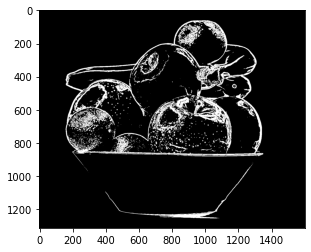

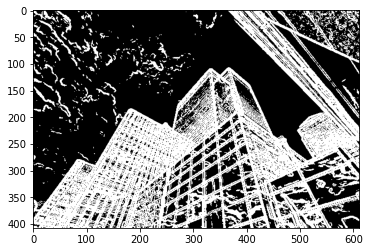

In [ ]:
std = 1 #@param {type:"number"}
threshold = 12 #@param {type:"number"}

MyCanny(img1,std,threshold)
MyCanny(img2,std,threshold)

Building Hystersis Queue: 100%|██████████| 1310/1310 [00:25<00:00, 52.15it/s]
Checking Neighbours: 45017it [1:06:03, 11.36it/s]
Building Hystersis Queue: 100%|██████████| 406/406 [00:03<00:00, 126.86it/s]
Checking Neighbours: 22153it [19:14, 19.19it/s]


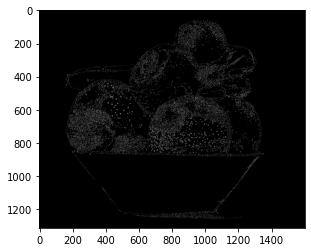

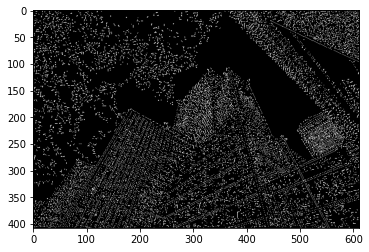

In [ ]:
low = .01 #@param {type:"number"}
high = .03 #@param {type:"number"}
low = low * 255
high = high * 255

MyCannyFull(img1,low,high)
MyCannyFull(img2,low,high)

In [ ]:
def energy_map(img):
    sobel_x = np.array([[-1.0, 0.0, 1.0],[-2.0, 0.0, 02.0],[-1.0, 0.0, 1.0]])
    sobel_y = np.array([[1.0, 2.0, 1.0],[0.0, 0.0, 0.0],[-1.0, -2.0, -1.0]])

    sobel_x = np.stack([sobel_x] * 3, axis=2)
    sobel_y = np.stack([sobel_y] * 3, axis=2)

    img = img.astype('float32')

    x = convolve(img, sobel_x)
    y = convolve(img, sobel_y)

    energy_map = (np.abs(x)+np.abs(y))
    energy_map = energy_map.sum(axis=2)

    return energy_map

In [ ]:
def findMin(matrix,i,j):
  height, width = matrix.shape
  value = 0
  index = 0
  
  if j == 0:
    firstPixel = matrix[i-1,j]
    secondPixel = matrix[i-1,j+1]
    
    if firstPixel <= secondPixel:
      index = j
      value = firstPixel
    else:
      index = j
      value = secondPixel
  
  elif j == (width - 1):
    firstPixel = matrix[i-1,j-1]
    secondPixel = matrix[i-1,j]
    
    if firstPixel <= secondPixel:
      index = j-1
      value = firstPixel
    else:
      index = j
      value = secondPixel
  
  else:
    firstPixel = matrix[i-1,j-1]
    secondPixel = matrix[i-1,j]
    thirdPixel = matrix[i-1,j+1]
    
    if firstPixel <= secondPixel:
      if firstPixel <= thirdPixel:
        index = j-1
        value = firstPixel

      else:
        index = j+1
        value = thirdPixel

    elif secondPixel <= thirdPixel:
      index = j
      value = secondPixel
      
    else:
      index = j+1
      value = thirdPixel

  return (index, value)

In [ ]:
def minimum_seam(img):

    height, width, _ = img.shape
    M = energy_map(img)

    path = np.zeros((height,width))


    for i in range(1, height):
        for j in range(0, width):

            if j == 0: #if the pixel is in first column
                path[i, j], min_energy = findMin(M,i,j)
            elif j == (width - 1): #if the pixel is in last column
                path[i, j], min_energy = findMin(M,i,j)
            else: #if the pixel is in any other column
                path[i, j], min_energy = findMin(M,i,j)

            M[i, j] += min_energy

    return M, path

In [ ]:
def resize_column(img):
    height, width, _ = img.shape

    M, path = minimum_seam(img)

    filter = np.ones((height, width), dtype=bool)

    j = np.argmin(M[-1])

    for i in reversed(range(height)):
        filter[i, j] = False
        j = int(path[i, j])

    filter = np.stack([filter] * 3, axis=2)
    img = img[filter].reshape((height, width - 1, 3))

    return img

In [ ]:
def crop_image(img, new_x,new_y):
    height, width, _ = img.shape

    for i in trange(width - new_x,desc="Reducing Width"):
        img = resize_column(img)

    img = np.rot90(img, 1, (0, 1))

    for i in trange(height - new_y,desc="Reducing Height"): 
      img = resize_column(img)

    img = np.rot90(img, 3, (0, 1))
    return img

In [ ]:
def energy_map2(img):
  x_bgr: torch.tensor = kornia.image_to_tensor(img)  # BxCxHxW
  x_bgr = x_bgr[None,...].float() / 255.
  x_rgb: torch.Tensor = kornia.color.bgr_to_rgb(x_bgr)
  map = kornia.filters.sobel(x_rgb)
  map = kornia.utils.tensor_to_image(map)
  map = np.sqrt(map[:,:,0]**2 + map[:,:,0]**2 + map[:,:,0]**2)
  return map

Reducing Width: 100%|██████████| 528/528 [29:48<00:00,  3.39s/it]
Reducing Heigh: 0it [00:00, ?it/s]


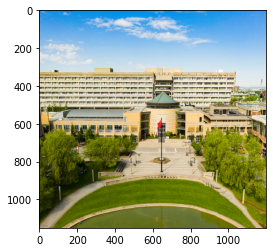

In [ ]:
new_x = 1200
new_y = 1151
newimg = crop_image(img3,new_x,new_y)
imshow(newimg)

Reducing Width: 0it [00:00, ?it/s]
Reducing Heigh: 100%|██████████| 431/431 [23:14<00:00,  3.24s/it]


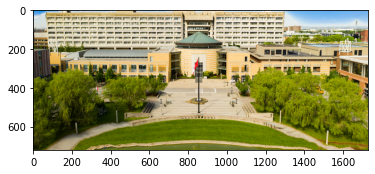

In [ ]:
new_x = 1728
new_y = 720
newimg = crop_image(img3,new_x,new_y)
imshow(newimg)

Reducing Heigh: 100%|██████████| 108/108 [00:38<00:00,  2.80it/s]


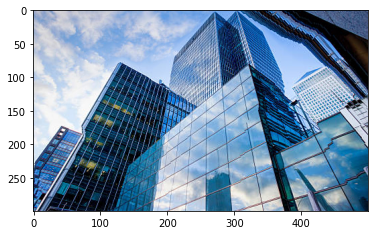

In [ ]:
new_x = 500
new_y = 300
newimg = crop_image(img2,new_x,new_y)
imshow(newimg)